In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [77]:
def dydx(x,y):
    #set the derivatives
    #our equation is d^2x/dx^2 = -y
    #so we can write
    #dydx = z
    #dzdx = -y
    
    #we will set y = y[0]
    #we will set z = y[1]
    
    #declare an array
    y_derivs = np.zeros(2)
    
    #set dydx = z
    y_derivs[0] = y[1]
    #set dzdx = -y
    y_derivs[1] = -1*y[0]
    
    #return arrays of dydx
    return y_derivs

In [78]:
def rk4_mv_core(dydx,xi,yi,nv,h):
    
    #declare k? arrays (? any digit 0-9)
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    k5 = np.zeros(nv)
    k6 = np.zeros(nv)
    
    #define coefficients
    a21 = 1/5
    a31 = 3/40
    a41 = 3/10
    a51 = (-11)/54
    a61 = 1631/55296
    
    a32 = 9/40
    a42 = (-9)/10
    a52 = 5/2
    a62 = 175/512
    
    a43 = 6/5
    a53 = (-70)/27
    a63 =575/13824
    
    a54 = 35/27
    a64 = 44275/110592
    
    a65 = 253/4096
    
    a2 = 1/5
    a3 = 3/10
    a4 = 3/5
    a5 = 1
    a6 = 7/8
    
    c1 = 37/378
    c2 = 0
    c3 = 250/621
    c4 = 125/594
    c5 = 0
    c6 = 512/1771
    
    c1_2 = 2825/27648
    c2_2 = 0
    c3_2 = 18575/48384
    c4_2 = 12525/55296
    c5_2 = 277/14336
    c6_2 = 1/4
    
    #define x step
    x_ipoh_k2 = xi + a2*h
    x_ipoh_k3 = xi + a3*h
    x_ipoh_k4 = xi + a4*h
    x_ipoh_k5 = xi + a5*h
    x_ipoh_k6 = xi + a6*h
    
    #define y step
    x_ipo_k2 =  a21*k1[:]
    x_ipo_k3 =  a31*k1[:] + a32*k2[:]
    x_ipo_k4 =  a41*k1[:] + a42*k2[:] + a43*k3[:]
    x_ipo_k5 =  a51*k1[:] + a52*k2[:] + a53*k3[:] + a54*k4[:]
    x_ipo_k6 =  a61*k1[:] + a62*k2[:] + a63*k3[:] + a64*k4[:] + a65*k5[:]
    
    #declare a temp y array
    y_temp = np.zeros(nv)
    
    
    #get k1 values
    y_derivs = dydx(xi,yi)
    k1[:] = h*y_derivs[:]
    
    #get the k2 values
    y_temp[:] = yi[:] + x_ipo_k2
    y_derivs = dydx(x_ipoh_k2,y_temp)
    k2[:] = h*y_derivs[:]
    
    #get k3 values
    y_temp[:] = yi[:] + x_ipo_k3
    y_derivs = dydx(x_ipoh_k3,y_temp)
    k3[:] = h*y_derivs[:]
    
    #get k4 values
    y_temp[:] = yi[:] + x_ipo_k4
    y_derivs = dydx(x_ipoh_k4,y_temp)
    k4[:] = h*y_derivs[:]
    
    #get k5 values
    y_temp[:] = yi[:] + x_ipo_k5
    y_derivs = dydx(x_ipoh_k5,y_temp)
    k5[:] = h*y_derivs[:]
    
    #get k6 values
    y_temp[:] = yi[:] + x_ipo_k6
    y_derivs = dydx(x_ipoh_k6,y_temp)
    k6[:] = h*y_derivs[:]
    
    #advance y by a step h
    yipo = yi + k6
    
    #make functions for finding error
    yn1 = yi[:] + c1*k1[:] + c2*k2[:] + c3*k3[:] + c4*k4[:] + c5*k5[:] + c6*k6[:] 
    yn1_2 = yi[:] + c1_2*k1[:] + c2_2*k2[:] + c3_2*k3[:] + c4_2*k4[:] + c5_2*k5[:] + c6_2*k6[:] 
    
    #this is an array (yipo = y i plus one)
    return yipo, yn1, yn1_2

In [89]:
def rk4_mv_ad(dydx,x_i,y_i,nv,h,tol):
    
    #define safety scale
    SAFETY = 0.9
    H_NEW_FAC = 2.0
    
    #set a maximum number of iterarions
    imax = 10000
    
    #set an iteration variable
    i = 0
    
    #create an error
    Delta = np.full(nv,2*tol)
    
    #remember the step
    h_step = h
    
    #adjust the step
    while(Delta.max()/tol > 1.0):
        
        yipo, yn1, yn1_2 = rk4_mv_core(dydx,x_i,y_i,nv,h)
        
        #compute an error
        Delta = np.fabs(yn1-yn1_2)
        print(yn1-yn1_2)
        
        #if the error is too large, decrease the step
        if (Delta.max()/tol > 1.0):
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
           
        #check iterations
        if (i>=imax): 
            print("too many iterations in rk4_mv_ad()")
            raise StopIteration("ending after i =",i)
            
        #iterate
        i+= 1
        
    #next time try to take a bigger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    #return the answer, a new step, and the step we actually took
    return y_2, h_new, h_step

In [90]:
def rk4_mv(dydx,a,b,y_a,tol):
    
    #dydx is the derivative wrt x
    #a is lower bound and b is the upper bound
    #y_a are the boundary conditions
    #tol is the tolerance for integrating y
    
    #define our starting step
    xi = a
    yi = y_a.copy()
    
    
    #an intial step size == very small
    h = 1.0e-4 * (b-a)
    
    #set number 0f iterations
    imax = 10000
   
    #set  an iteration variable
    i = 0
    
    #set the number of coupled odes to the size of y_a
    nv = len(y_a)
    
    #set the numper of coupled odes to the size of y_a
    x = np.full(1,a)
    y = np.full((1,nv),y_a)
    
    #set initial conditions
    flag = 1
    
    #loop until we reach th right side
    while(flag):
        
        #calculate y_i+1
        yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
        
        #update the step
        h = h_new
        
        #prevent an overshoot
        if (xi+h_step>b):
            
            #take a smaller step
            h = b-xi
            
            #recalculate y_i+1
            yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
            
            #break
            
            flag = 0
            
        #update values
        xi += h_step
        yi[:] = yi_new[:]
        
        #add the step to the arrays
        x = np.append(x,xi)
        y_new = np.zeros((len(x),nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
        
        #prevent too many interations
        if(i>=imax):
            
            print("Maximum iterations reached.")
            raise StopIteration("Iteration number =",i)
            
        #iterate
        i += 1
        
        #output some information
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb=%9.8f" % (i, xi, h_step, b)
        print(s)
        
        #break if new xi is == b
        if(xi==b):
            flag = 0
            
    return x,y

In [91]:
a = 0.0
b = 2.0*np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

#perform the integration
x,y = rk4_mv(dydx,a,b,y_0,tolerance)

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628

[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
[1.13628207e-05 0.00000000e+00]
too many iterations in rk4_mv_ad()


StopIteration: ('ending after i =', 10000)

In [ ]:
plt.plot(x,y[:,0],'o',label='y(x)')
plt.plot(x,y[:,1],'o',label='dydx(x)')
xx = np.linspace(0,2.0*np.pi,1000)
plt.plot(xx,np.sin(xx),label='sin(x)')
plt.plot(xx,np.cos(xx),label='cos(x)')
plt.xlabel('x')
plt.ylabel('y, dy/dx')
plt.legend(frameon=False)

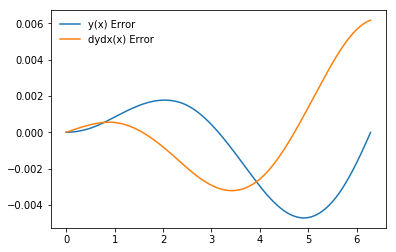

In [83]:
sin = np.sin(x)
cosin = np.cos(x)

y_error = (y[:,0]-sin)
dydx_error = (y[:,1]-cosin)

plt.plot(x,y_error,label="y(x) Error")
plt.plot(x,dydx_error, label="dydx(x) Error")
plt.legend(frameon=False)